In [1]:
import numpy as np
import os

from glob import glob

from keras.src.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.text import text_to_word_sequence
## 라벨인코더-> 카테고리형 문자를 숫자로 자동 변환해주는 역할
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 딥러닝 모델을 만들자!!!!!!!
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from tensorflow.keras.preprocessing import *

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
import os
print(os.getcwd())

C:\Users\Administrator\Documents\deep\deep01


In [5]:
from pathlib import Path
base = Path("cars2") # 현재 폴더 경로

audi_files = sorted((base/"audi").glob("*.jpg"))
audi_files[:3]
lamborghini_files = sorted((base/"lamborghini").glob("*.jpg"))
lamborghini_files[:3]
mercedes_files = sorted((base/"mercedes").glob("*.jpg"))
mercedes_files[:3]


[WindowsPath('cars2/mercedes/1.jpg'),
 WindowsPath('cars2/mercedes/10.jpg'),
 WindowsPath('cars2/mercedes/11.jpg')]

In [6]:
data_files = audi_files + lamborghini_files +  mercedes_files#리스트
data_files[0], len(data_files)

(WindowsPath('cars2/audi/1.jpg'), 64)

In [7]:
img0 = cv2.imread(data_files[0])
img0

array([[[208, 219, 233],
        [209, 220, 234],
        [210, 221, 235],
        ...,
        [222, 217, 214],
        [226, 221, 218],
        [169, 164, 161]],

       [[215, 226, 240],
        [215, 226, 240],
        [217, 228, 242],
        ...,
        [222, 217, 214],
        [225, 220, 217],
        [169, 164, 161]],

       [[222, 233, 247],
        [222, 233, 247],
        [223, 234, 248],
        ...,
        [222, 217, 214],
        [225, 220, 217],
        [169, 164, 161]],

       ...,

       [[108, 112, 130],
        [113, 118, 133],
        [122, 125, 140],
        ...,
        [207, 210, 215],
        [207, 210, 215],
        [207, 210, 215]],

       [[104, 108, 126],
        [111, 116, 131],
        [117, 120, 135],
        ...,
        [210, 213, 218],
        [210, 213, 218],
        [210, 213, 218]],

       [[ 99, 103, 121],
        [111, 116, 131],
        [121, 124, 139],
        ...,
        [212, 215, 220],
        [212, 215, 220],
        [212, 215, 220]]

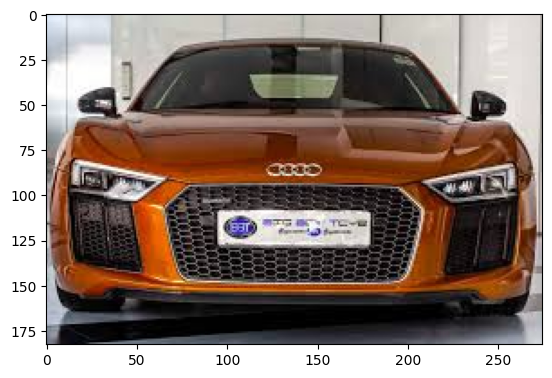

In [8]:
plt.imshow(img0)

In [9]:
def make_file(data_height, data_width, channel_n, data_list_n):
    # 각 이미지마다 라벨링 필요
    # 각 이미지를 읽어서 해당폴더명을 추출한다음에 해당폴더명이 cat(0), dog(1)
    label = []

    ## 텐서플로우 사이트에서 제공하는 모델사용하려고 함.
    ## 이미지를 4차원으로 만들어서 넣어주면 됨.
    ## 이미지 스케일링 작업을 한 후 4차원을 만들어 넣어줄 4차원 빈 리스트를 만들어 두자.
    images = np.zeros((data_list_n, data_height, data_width, channel_n))
    # print(images.shape) # (4000, 150, 150, 3)

    for i, image in enumerate(data_files):
        # print(i, image)
        # print(type(image)) # <class 'pathlib.WindowsPath'>
        folder = str(image).split("\\")[1] #['img-animal', 'cat', 'cat.0.jpg']
        # print(folder)
        result = 0 # audi이면 0번으로 설정
        if folder == 'lamborghini':
            result = 1
        if folder == 'mercedes':
            result = 2
        label.append(result)
        # if i % 10 == 0:
        #     print(i, image, "last_label=", result)
        #     print("label: ", label)
        #     print("-----------------------------")

        # 이미지는 255로 나누어 계산할 숫자크기를 줄여서 스케일링을 해주는 편임.
        # 1. 이미지를 읽자.
        image2 = cv2.imread(image)
        # 2. 같은 사이즈로 맞추어 주자 가로 150, 세로 150
        # 3. 255로 나누어 스케일링을 하자.
        image3 = cv2.resize(image2, (data_height, data_width)) / 255
        #print(image3)
        # 3차원 데이터를 앞에 i붙여서 4차원으로 만들어줌.
        images[i, :, :, :] = image3

    return np.array(label), images

In [10]:
labels, images = make_file(150, 150, 3, 64)

In [11]:
labels[:10], labels[-11 : -1]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [12]:
np.unique(labels)

array([0, 1, 2])

In [13]:
X = images
y = labels

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state=55,
                                                    shuffle=True
                                                   )
print(X_train.shape, X_test.shape)

(51, 150, 150, 3) (13, 150, 150, 3)


In [15]:
# 모델 설정
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [16]:
cnn_base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3)
)
cnn_base.trainable = False
# 역전파를 해도 가중치가 업데이트되지 않음

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [33]:
model = Sequential()
model.add(tf.keras.Input(shape=(150, 150, 3)))
model.add(cnn_base)
# 이 줄이 핵심: 그냥 GlobalAveragePooling2D() 호출이 아니라 add로 넣어야 함
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation="softmax"))

In [36]:
# 옵티마이저, 손실함수 설정
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

In [37]:
# 훈련시키자
# 콜백함수 --> 조기종료, 가장 성능이 좋을 때를 체크해서 모델에 대한 정보+가중치를 저장(체크포인트)
es = EarlyStopping(patience=3, restore_best_weights=True)
cp = ModelCheckpoint('best_cnn_final.h5')

In [38]:
cnn_history = model.fit(
                X_train,
                y_train,
                batch_size=8,
                epochs=5,
                validation_data= (X_test, y_test),
                callbacks=[es, cp],
                verbose=2
)

Epoch 1/5


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


7/7 - 20s - 3s/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00
Epoch 2/5


7/7 - 4s - 588ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00
Epoch 3/5


7/7 - 4s - 541ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00
Epoch 4/5


7/7 - 7s - 984ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00


In [23]:
test_result = model.evaluate(X_test,y_test)
test_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3077 - loss: 0.7523


[0.7523049116134644, 0.3076923191547394]

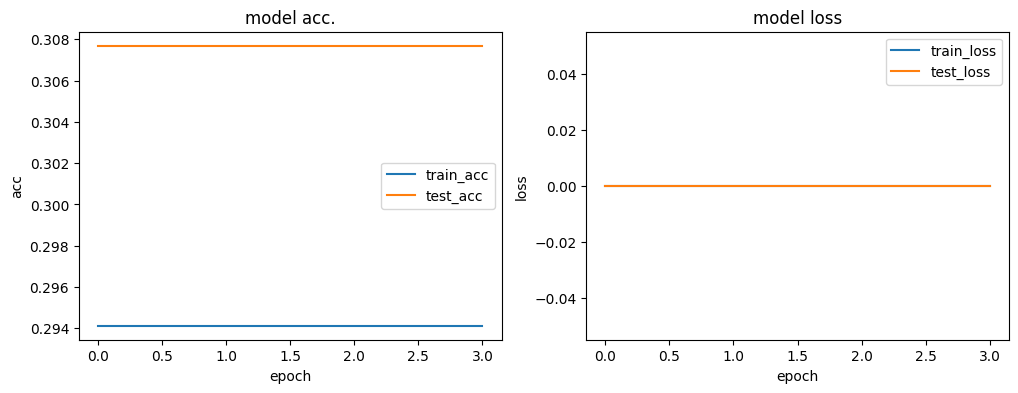

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])

In [40]:
load_model_final = load_model('./best_cnn_final.h5')
load_model_final

<Sequential name=sequential_2, built=True>

In [41]:
final_result2 = load_model_final.predict(X_test)
final_result2[:10]

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis -1 of a tensor of shape (13, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [42]:
np.mean(final_result2 == y_test)

np.float64(0.3076923076923077)

In [43]:
# CNN model network
from tensorflow.keras.layers import Dropout
from tensorflow.keras import datasets, layers, models
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(1, activation='softmax'))

# model2.summary()

In [44]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

In [45]:
cnn2_history = model2.fit(
                X_train,
                y_train,
                batch_size=8,
                epochs=10,
                validation_data= (X_test, y_test),
                callbacks=[es, cp],
                verbose=2
)

Epoch 1/10


7/7 - 7s - 932ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00
Epoch 2/10


7/7 - 3s - 475ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00
Epoch 3/10


7/7 - 2s - 262ms/step - accuracy: 0.2941 - loss: 0.0000e+00 - val_accuracy: 0.3077 - val_loss: 0.0000e+00


In [46]:
test_result2 = model2.evaluate(X_test,y_test)
test_result2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3077 - loss: 0.0000e+00


[0.0, 0.3076923191547394]

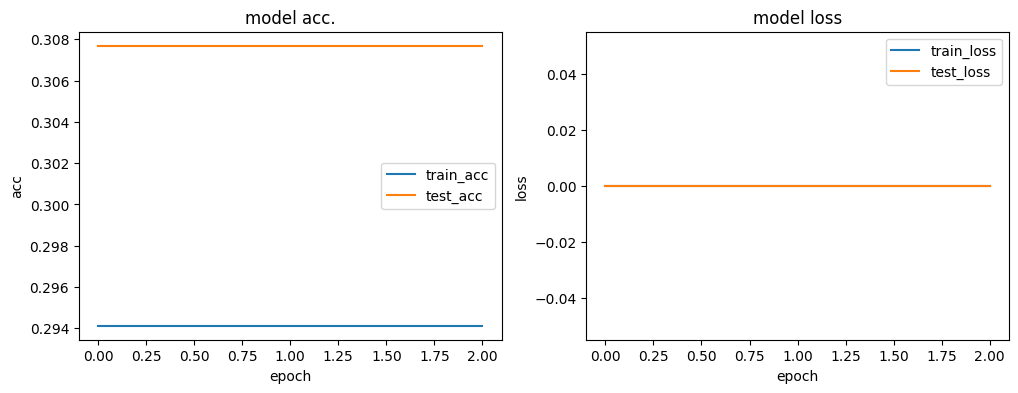

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn2_history.history['accuracy'])
plt.plot(cnn2_history.history['val_accuracy'])
plt.title('model acc.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn2_history.history['loss'])
plt.plot(cnn2_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])

In [48]:
load_model_final = load_model('./best_cnn_final.h5')
load_model_final

<Sequential name=sequential_3, built=True>

In [49]:
final_result2 = load_model_final.predict(X_test)
final_result2[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [50]:
np.mean(final_result2 == y_test)

np.float64(0.3076923076923077)